<a href="https://colab.research.google.com/github/costpetrides/Fluid-Dynamics-Navier-Stokes/blob/main/Raleigh-Taylor-Instability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install imageio

<ipython-input-3-06ad4fc47ae8>:126: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(f'frames/frame_{i:04d}.png')


GIF has been created and saved as 'simulation.gif'


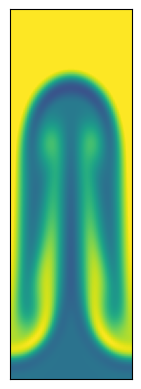

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os

def main():
    """ Finite Volume simulation """

    # Simulation parameters
    N                      = 64  # resolution N x 3N
    boxsizeX               = 0.5
    boxsizeY               = 1.5
    gamma                  = 1.4  # ideal gas gamma
    courant_fac            = 0.4
    t                      = 0
    tEnd                   = 15
    tOut                   = 0.1  # draw frequency
    useSlopeLimiting       = False
    plotRealTime = True  # switch on for plotting as the simulation goes along

    # Mesh
    dx = boxsizeX / N
    vol = dx**2
    xlin = np.linspace(0.5*dx, boxsizeX-0.5*dx, N)
    ylin = np.linspace(0.5*dx, boxsizeY-0.5*dx, 3*N)
    Y, X = np.meshgrid(ylin, xlin)

    # Generate Initial Conditions - heavy fluid on top of light, with perturbation
    g = -0.1  # gravity
    w0 = 0.0025
    P0 = 2.5
    rho = 1. + (Y > 0.75)
    vx = np.zeros(X.shape)
    vy = w0 * (1-np.cos(4*np.pi*X)) * (1-np.cos(4*np.pi*Y/3))
    P = P0 + g * (Y-0.75) * rho

    rho, vx, vy, P = addGhostCells(rho, vx, vy, P)

    # Get conserved variables
    Mass, Momx, Momy, Energy = getConserved(rho, vx, vy, P, gamma, vol)

    # Create a folder to store frames
    if not os.path.exists('frames'):
        os.makedirs('frames')

    outputCount = 1

    # Simulation Main Loop
    while t < tEnd:

        # get Primitive variables
        rho, vx, vy, P = getPrimitive(Mass, Momx, Momy, Energy, gamma, vol)

        # get time step (CFL) = dx / max signal speed
        dt = courant_fac * np.min(dx / (np.sqrt(gamma*P/rho) + np.sqrt(vx**2+vy**2)))
        plotThisTurn = False
        if t + dt > outputCount*tOut:
            dt = outputCount*tOut - t
            plotThisTurn = True

        # Add Source (half-step)
        Mass, Momx, Momy, Energy = addSourceTerm(Mass, Momx, Momy, Energy, g, dt/2)

        # get Primitive variables
        rho, vx, vy, P = getPrimitive(Mass, Momx, Momy, Energy, gamma, vol)

        # calculate gradients
        rho_dx, rho_dy = getGradient(rho, dx)
        vx_dx,  vx_dy  = getGradient(vx,  dx)
        vy_dx,  vy_dy  = getGradient(vy,  dx)
        P_dx,   P_dy   = getGradient(P,   dx)

        # slope limit gradients
        if useSlopeLimiting:
            rho_dx, rho_dy = slopeLimit(rho, dx, rho_dx, rho_dy)
            vx_dx,  vx_dy  = slopeLimit(vx , dx, vx_dx,  vx_dy )
            vy_dx,  vy_dy  = slopeLimit(vy , dx, vy_dx,  vy_dy )
            P_dx,   P_dy   = slopeLimit(P  , dx, P_dx,   P_dy  )

        # extrapolate half-step in time
        rho_prime = rho - 0.5*dt * ( vx * rho_dx + rho * vx_dx + vy * rho_dy + rho * vy_dy)
        vx_prime  = vx  - 0.5*dt * ( vx * vx_dx + vy * vx_dy + (1/rho) * P_dx )
        vy_prime  = vy  - 0.5*dt * ( vx * vy_dx + vy * vy_dy + (1/rho) * P_dy )
        P_prime   = P   - 0.5*dt * ( gamma*P * (vx_dx + vy_dy)  + vx * P_dx + vy * P_dy )

        # extrapolate in space to face centers
        rho_XL, rho_XR, rho_YL, rho_YR = extrapolateInSpaceToFace(rho_prime, rho_dx, rho_dy, dx)
        vx_XL,  vx_XR,  vx_YL,  vx_YR  = extrapolateInSpaceToFace(vx_prime,  vx_dx,  vx_dy,  dx)
        vy_XL,  vy_XR,  vy_YL,  vy_YR  = extrapolateInSpaceToFace(vy_prime,  vy_dx,  vy_dy,  dx)
        P_XL,   P_XR,   P_YL,   P_YR   = extrapolateInSpaceToFace(P_prime,   P_dx,   P_dy,   dx)

        # compute fluxes (local Lax-Friedrichs/Rusanov)
        flux_Mass_X, flux_Momx_X, flux_Momy_X, flux_Energy_X = getFlux(rho_XL, rho_XR, vx_XL, vx_XR, vy_XL, vy_XR, P_XL, P_XR, gamma)
        flux_Mass_Y, flux_Momy_Y, flux_Momx_Y, flux_Energy_Y = getFlux(rho_YL, rho_YR, vy_YL, vy_YR, vx_YL, vx_YR, P_YL, P_YR, gamma)

        # update solution
        Mass   = applyFluxes(Mass, flux_Mass_X, flux_Mass_Y, dx, dt)
        Momx   = applyFluxes(Momx, flux_Momx_X, flux_Momx_Y, dx, dt)
        Momy   = applyFluxes(Momy, flux_Momy_X, flux_Momy_Y, dx, dt)
        Energy = applyFluxes(Energy, flux_Energy_X, flux_Energy_Y, dx, dt)

        # Add Source (half-step)
        Mass, Momx, Momy, Energy = addSourceTerm(Mass, Momx, Momy, Energy, g, dt/2)

        # update time
        t += dt

        # Save frame if we need to plot
        if plotThisTurn or (t >= tEnd):
            plt.cla()
            plt.imshow(rho.T)
            plt.clim(0.4, 2.0)
            ax = plt.gca()
            ax.invert_yaxis()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_aspect('equal')

            # Save current frame as image
            plt.savefig(f'frames/frame_{outputCount:04d}.png')
            outputCount += 1

    # Create GIF from frames
    with imageio.get_writer('simulation.gif', mode='I', duration=0.1) as writer:
        for i in range(1, outputCount):
            image = imageio.imread(f'frames/frame_{i:04d}.png')
            writer.append_data(image)

    # Cleanup by removing the frames directory
    for i in range(1, outputCount):
        os.remove(f'frames/frame_{i:04d}.png')
    os.rmdir('frames')

    print("GIF has been created and saved as 'simulation.gif'")
    return 0

if __name__ == "__main__":
    main()
